# BTC Predictor

In [706]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [707]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *

PATH='data/stock/'

## Config


In [708]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

lookahead = 45
percentIncrease = 1.005
recordsCount = 110000
testRecordsCount = 10000
trainRecordsCount = 100000
trainRatio = 0.9
lr = 1e-4
modelName = 'btcBinaryClassificationModel'

## Create datasets

You can download the datasets used [here](https://www.kaggle.com/c/titanic/data).

Feature Space:
* train: Training set provided by competition
* test: testing set

In [709]:
table_names = ['btc-bitstamp-2012-01-01_to_2018-01-08']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [710]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [711]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains Passenger info such as Gender, Age, Ticket, Fare and whether Survived, the prediction variable
* test: Same as training table, w/o Survived


In [712]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


The following returns summarized aggregate information to each table accross each field.

In [713]:
# for t in tables: display(DataFrameSummary(t).summary())

In [719]:
# trim to x records for now
# TODO: remove this
train = train.tail(recordsCount)
len(train)

110000

## Data Cleaning / Feature Engineering

In [714]:
def cleanData(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
#     df.fillna(method='bfill')
#     df = df.replace(np.nan,df.mean())
    return df

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [715]:
train= tables[0]

In [716]:
len(train)

3161057

Time modifications

In [717]:
#convert to date objects
train["Timestamp"] = pd.to_datetime(train["Timestamp"], unit='s')
train.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


SET DEPENDENT VARIABLE ACTION

In [718]:
# edit columns
train["VolumeBTC"] = train["Volume_(BTC)"]
train.drop('Volume_(BTC)',1,inplace=True)
train["VolumeCurrency"] = train["Volume_(Currency)"]
train.drop('Volume_(Currency)',1,inplace=True)

# delete unused columns
train.drop('VolumeCurrency',1,inplace=True)
train.drop('Weighted_Price',1,inplace=True)
train.head()

,Timestamp,Open,High,Low,Close,VolumeBTC
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581


In [720]:
# remove all 0 values 
train = cleanData(train)
len(train)

110000

In [721]:
# add technical analysis
train = add_all_ta_features(train, "Open", "High", "Low", "Close", "VolumeBTC", fillna=False)
# train = cleanData(train)
# # todo: need to fill in data instead of removing
# len(train)

In [722]:
train['action'] =  train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close']

# train['action'] = 0;
# train.loc[train['Close'].rolling(window=lookahead).max() > train['Close'], 'action'] = 1
# train.loc[train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close'], 'action'] = 2

train.action = train.action.astype(int)

# target count by category
len(train[train.action==2]),len(train[train.action==1]),len(train[train.action==0])

(0, 51332, 58668)

In [723]:
# add all date time values
add_datepart(train, "Timestamp", drop=False)
train['hour'] = train.Timestamp.dt.hour;
train['minute'] = train.Timestamp.dt.minute;
len(train)

110000

## Split validation and test sets

In [724]:
# todo: make this into a percentage instead of hardcoding the test set
test = train.tail(testRecordsCount)
test.reset_index(inplace=True)
train = train.head(trainRecordsCount)
train.reset_index(inplace=True)
len(train),len(test)

(100000, 10000)

In [725]:
train.to_feather(f'{PATH}train')
test.to_feather(f'{PATH}test')

## Create features

In [726]:
train = pd.read_feather(f'{PATH}train')
test = pd.read_feather(f'{PATH}test')

In [727]:
train.tail(50).T.head(100)

,99950,99951,99952,99953,99954,99955,99956,99957,99958,99959,99960,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
index,3151007,3151008,3151009,3151010,3151011,3151012,3151013,3151014,3151015,3151016,3151017,3151018,3151019,3151020,3151021,3151022,3151023,3151024,3151025,3151026,3151027,3151028,3151029,3151030,3151031,3151032,3151033,3151034,3151035,3151036,3151037,3151038,3151039,3151040,3151041,3151042,3151043,3151044,3151045,3151046,3151047,3151048,3151049,3151050,3151051,3151052,3151053,3151054,3151055,3151056
Timestamp,2018-01-01 00:31:00,2018-01-01 00:32:00,2018-01-01 00:33:00,2018-01-01 00:34:00,2018-01-01 00:35:00,2018-01-01 00:36:00,2018-01-01 00:37:00,2018-01-01 00:38:00,2018-01-01 00:39:00,2018-01-01 00:40:00,2018-01-01 00:41:00,2018-01-01 00:42:00,2018-01-01 00:43:00,2018-01-01 00:44:00,2018-01-01 00:45:00,2018-01-01 00:46:00,2018-01-01 00:47:00,2018-01-01 00:48:00,2018-01-01 00:49:00,2018-01-01 00:50:00,2018-01-01 00:51:00,2018-01-01 00:52:00,2018-01-01 00:53:00,2018-01-01 00:54:00,2018-01-01 00:55:00,2018-01-01 00:56:00,2018-01-01 00:57:00,2018-01-01 00:58:00,2018-01-01 00:59:00,2018-01-01 01:00:00,2018-01-01 01:01:00,2018-01-01 01:02:00,2018-01-01 01:03:00,2018-01-01 01:04:00,2018-01-01 01:05:00,2018-01-01 01:06:00,2018-01-01 01:07:00,2018-01-01 01:08:00,2018-01-01 01:09:00,2018-01-01 01:10:00,2018-01-01 01:11:00,2018-01-01 01:12:00,2018-01-01 01:13:00,2018-01-01 01:14:00,2018-01-01 01:15:00,2018-01-01 01:16:00,2018-01-01 01:17:00,2018-01-01 01:18:00,2018-01-01 01:19:00,2018-01-01 01:20:00
Open,13699.9,13686.4,13721.4,13711.4,13665,13727.1,13712,13669.3,13669.3,13727.5,13671.5,13647.6,13633.2,13671,13664,13661.7,13680.8,13716,13720,13720,13662.4,13732.8,13704.5,13693.6,13668.5,13622,13601,13628.5,13633.6,13635.1,13636.1,13678.9,13656,13675.4,13676.1,13679.5,13660,13600,13608,13587,13567,13614,13600,13600,13600,13567.8,13597,13643.9,13642.9,13675.2
High,13699.9,13721.4,13754.1,13727.9,13727.7,13727.1,13728.2,13710.9,13707.8,13731.5,13672.4,13671.7,13671,13671,13682.8,13680.8,13707.8,13720,13720,13742.3,13733.9,13733.1,13704.5,13693.6,13668.5,13630,13630,13651.9,13668.5,13681.4,13678.9,13680,13675.6,13676.1,13680,13679.7,13679.6,13610.2,13609.8,13595.4,13614,13614.1,13600,13600,13600,13599,13647,13643.9,13675.3,13694.1
Low,13672.6,13669.9,13711.4,13655.4,13665,13727,13668.4,13669.3,13669.3,13632.2,13646.6,13632.1,13632,13632,13632,13661.7,13655.7,13700,13700,13653.2,13662.4,13669.6,13668.5,13690.8,13622,13600.3,13601,13601,13633.6,13635.1,13636.1,13656,13656,13657,13660,13660,13600,13598,13564,13564,13564.1,13585.3,13565.7,13600,13565.2,13564.1,13576.3,13604.7,13605,13647.5
Close,13699,13721.4,13711.4,13665,13727.6,13727,13701.5,13707.8,13707.8,13706,13671.7,13633.2,13632,13664,13661.7,13680.8,13707.8,13720,13720,13655.5,13710,13669.6,13704.5,13690.8,13622,13630,13623.4,13651.8,13668.5,13681.4,13678.9,13656,13674.7,13676.1,13666.7,13660,13600,13610.2,13574,13567,13614,13614.1,13600,13600,13599,13597,13645,13618.5,13647.5,13694.1
VolumeBTC,1.19917,20.2918,0.505361,4.96789,0.110723,0.162831,11.702,3.17072,0.312759,5.12813,0.611623,4.33532,0.871489,1.78837,2.4758,0.116015,0.775738,6.85135,0.574298,3.66799,1.15904,1.27812,0.109093,0.0459614,13.2409,1.02044,0.19926,2.3952,1.49931,0.531898,9.46679,1.30616,1.14318,0.179416,0.860276,1.26541,8.65339,3.09669,15.4342,4.19633,1.03008,1.24946,0.272052,0.0454431,0.384441,0.885178,4.08005,0.283713,12.4654,18.4473
volume_adi,2.13399,21.4049,19.7788,-4.16131,-3.5455,-0.0521436,1.12261,3.9875,3.01482,2.802,3.06731,-3.49928,-4.94883,0.276479,1.56734,0.535386,0.889966,7.6253,7.42507,-2.90002,-3.08912,-0.8935,-1.16909,0.0633988,-13.2865,-12.2205,1.12832,2.50214,3.89357,2.03121,9.99869,8.16063,-0.26887,1.21671,-0.104475,-1.5493,-9.9188,-5.5567,-5.61203,-12.1141,-2.37607,2.27871,1.52151,0.272052,0.36235

In [728]:
# display(DataFrameSummary(train).summary())
# break break break now

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [729]:
train.head()

,index,Timestamp,Open,High,Low,Close,VolumeBTC,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_cr,action,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
0,3051057,2017-10-23 14:41:00,5745.0,5745.0,5738.00,5738.0,6.247508,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1000.0,7.000000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,5738.000000,5738.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,2017,10,43,23,0,296,False,False,False,False,False,False,1508769660,14,41
1,3051058,2017-10-23 14:42:00,5738.0,5745.0,5738.00,5745.0,10.207588,3.960080,10.207588,NaN,NaN,NaN,NaN,NaN,1000.0,7.000000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.073962,0.038928,0.035035,5741.640000,5741.566038,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.121994,0.121994,0,2017,10,43,23,0,296,False,False,False,False,False,False,1508769720,14,42
2,3051059,2017-10-23 14:43:00,5745.0,5745.0,5739.03,5745.0,0.602053,10.809641,0.000000,NaN,NaN,-39.518186,NaN,0.012453,1000.0,6.632726,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.096593,0.060206,0.036387,5742.850746,5742.754153,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.121994,0,2017,10,43,23,0,296,False,False,False,False,False,False,1508769780,14,43
3,3051060,2017-10-23 14:44:00,5745.0,5745.0,5713.90,5725.0,7.036934,-1.411732,-7.036934,NaN,NaN,63.413092,NaN,-0.024498,1000.0,13.396347,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,-0.222427,-0.021978,-0.200449,5737.838850,5738.061277,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.365123,NaN,24.652591,NaN,NaN,NaN,NaN,NaN,-0.348129,-0.226560,0,2017,10,43,23,0,296,False,False,False,False,False,False,1508769840,14,44
4,3051061,2017-10-23 14:45:00,5725.0,5725.0,5690.00,5690.0,112.226667,-114.240451,-112.226667,NaN,NaN,-6139.353750,NaN,-0.710599,1000.0,18.332840,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,-1.028526,-0.267772,-0.760755,5726.681621,5727.710148,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.588036,NaN,-25.703138,NaN,NaN,NaN,NaN,NaN,-0.611354,-0.836528,0,2017,10,43,23,0,296,False,False,False,False,False,False,1508769900,14,45


Identify categorical vs continuous variables.  PassengerId serves as the unique identifier for each row.

In [730]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# techincal_indicators = ['volume_adi','volume_obv','volume_obvm','volume_cmf','volume_nvi','volatility_bbh',
# 'volatility_bbl','volatility_atr','volatility_bbm','trend_mass_index','trend_macd','trend_macd_signal',
# 'trend_kst','trend_kst_sig','trend_kst_diff','trend_macd_diff','trend_ema_fast','trend_ema_slow','trend_adx',
# 'trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_ichimoku_a','trend_ichimoku_b','momentum_rsi','momentum_mfi',
# 'momentum_tsi','momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao']

contin_vars = ['Open', 'Close','High', 'Low', 'VolumeBTC', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao']
# 'others_dr','others_cr'

# contin_vars = [base_vars+techincal_indicators]

index='Timestamp'
dep = 'action'
n = len(train); n

test = test.set_index(index)
train = train.set_index(index)

len(contin_vars)

58

In [731]:
train = train[cat_vars+contin_vars+[dep]].copy()
# , index

In [732]:
# test[dep] = 0 
test = test[cat_vars+contin_vars+[dep]].copy()
# , index


In [733]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
#     todo: maybe change dep variable to category here for multiclass option

In [734]:
apply_cats(test, train)
# test

In [735]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

We can now process our data...

In [736]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)

In [737]:
y.shape

(100000,)

In [738]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)
train.head(30).T.head(70)

Timestamp,2017-10-23 14:41:00,2017-10-23 14:42:00,2017-10-23 14:43:00,2017-10-23 14:44:00,2017-10-23 14:45:00,2017-10-23 14:46:00,2017-10-23 14:47:00,2017-10-23 14:48:00,2017-10-23 14:49:00,2017-10-23 14:50:00,2017-10-23 14:51:00,2017-10-23 14:52:00,2017-10-23 14:53:00,2017-10-23 14:54:00,2017-10-23 14:55:00,2017-10-23 14:56:00,2017-10-23 14:57:00,2017-10-23 14:58:00,2017-10-23 14:59:00,2017-10-23 15:00:00,2017-10-23 15:01:00,2017-10-23 15:02:00,2017-10-23 15:03:00,2017-10-23 15:04:00,2017-10-23 15:05:00,2017-10-23 15:06:00,2017-10-23 15:07:00,2017-10-23 15:08:00,2017-10-23 15:09:00,2017-10-23 15:10:00
TimestampYear,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
TimestampMonth,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
TimestampWeek,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
TimestampDay,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
hour,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15
minute,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10
TimestampDayofweek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TimestampDayofyear,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [739]:
nas={}

In [740]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,...,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,volume_adi_na,volume_obvm_na,volume_cmf_na,volume_fi_na,volume_em_na,volume_vpt_na,volatility_bbh_na,volatility_bbl_na,volatility_bbm_na,volatility_kcc_na,volatility_kch_na,volatility_kcl_na,volatility_dch_na,volatility_dcl_na,trend_adx_na,trend_adx_pos_na,trend_adx_neg_na,trend_vortex_ind_pos_na,trend_vortex_ind_neg_na,trend_vortex_diff_na,trend_trix_na,trend_mass_index_na,trend_cci_na,trend_dpo_na,trend_kst_na,trend_kst_sig_na,trend_kst_diff_na,trend_ichimoku_a_na,trend_ichimoku_b_na,momentum_rsi_na,momentum_mfi_na,momentum_tsi_na,momentum_uo_na,momentum_stoch_na,momentum_stoch_signal_na,momentum_wr_na,momentum_ao_na
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-23 14:41:00,1,2,2,23,15,42,1,2,1,1,1,1,1,1,-1.191094,-1.192702,-1.192,-1.191729,-0.262773,-1.732014,-0.038015,-0.001936,0.000344,0.033839,0.041263,0.021301,0.021737,-0.681201,-0.936692,-0.294097,-0.295466,-0.29207,-0.230308,-0.24162,-0.292527,-0.294137,-0.29108,-0.049457,-0.057453,-0.294393,-0.294681,-0.426899,-0.344356,-0.027584,-0.029562,0.000211,-1.192557,-1.192369,-0.12251,-0.160543,...,0.027142,0.027966,-0.007859,-0.293684,-0.293958,-0.003311,-0.003209,-0.029876,0.005654,0.080908,0.081625,0.080908,0.019706,316.226185,105.404512,72.540733,223.604562,84.509509,223.604562,72.540733,72.540733,72.540733,105.404512,105.404512,105.404512,72.540733,72.540733,84.509509,84.509509,84.509509,84.509509,84.509509,84.509509,49.989999,51.28917,72.540733,72.540733,47.66264,43.841498,43.841498,44.269451,36.023621,316.226185,87.700101,316.226185,52.69514,87.700101,81.643534,87.700101,55.039105
2017-10-23 14:42:00,1,2,2,23,15,43,1,2,1,1,1,1,1,1,-1.192778,-1.191018,-1.192,-1.191729,-0.066790,-1.732014,0.064624,0.441050,0.000344,0.033839,0.041263,0.021301,0.021737,-0.681201,-0.936692,-0.294097,-0.295466,-0.29207,-0.230308,-0.24162,-0.292527,-0.294137,-0.29108,-0.049457,-0.057453,-0.294393,-0.294681,-0.426899,-0.344356,-0.025757,-0.028535,0.002792,-1.191681,-1.191511,-0.12251,-0.160543,...,0.027142,0.027966,-0.007859,-0.293684,-0.293958,4.291339,-0.003209,7.281737,0.005654,0.080908,0.081625,0.080908,0.019706,-0.003162,105.404512,72.540733,223.604562,84.509509,223.604562,72.540733,72.540733,72.540733,105.404512,105.404512,105.404512,72.540733,72.540733,84.509509,84.509509,84.509509,84.509509,84.509509,84.509509,49.989999,51.28917,72.540733,72.540733,47.66264,43.841498,43.841498,44.269451,36.023621,-0.003162,87.700101,-0.003162,52.69514,87.700101,81.643534,87.700101,55.039105


In [741]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,...,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,volume_adi_na,volume_obvm_na,volume_cmf_na,volume_fi_na,volume_em_na,volume_vpt_na,volatility_bbh_na,volatility_bbl_na,volatility_bbm_na,volatility_kcc_na,volatility_kch_na,volatility_kcl_na,volatility_dch_na,volatility_dcl_na,trend_adx_na,trend_adx_pos_na,trend_adx_neg_na,trend_vortex_ind_pos_na,trend_vortex_ind_neg_na,trend_vortex_diff_na,trend_trix_na,trend_mass_index_na,trend_cci_na,trend_dpo_na,trend_kst_na,trend_kst_sig_na,trend_kst_diff_na,trend_ichimoku_a_na,trend_ichimoku_b_na,momentum_rsi_na,momentum_mfi_na,momentum_tsi_na,momentum_uo_na,momentum_stoch_na,momentum_stoch_signal_na,momentum_wr_na,momentum_ao_na
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:21:00,2,1,1,1,2,22,1,1,1,2,1,2,1,2,0.721740,0.721784,0.717234,0.727470,-0.562929,1.732088,0.556930,0.005984,0.374871,0.017523,-0.251507,-0.41109,0.331493,3.732039,0.320090,0.702109,0.710957,0.706570,-0.230308,-0.24162,0.705055,0.703542,0.706566,-0.049457,-0.057453,0.703523,0.711746,2.342475,-0.344356,-0.634803,-0.872694,0.541659,0.709531,0.715766,-0.312704,0.316429,...,-0.430858,-0.614159,0.529602,0.721891,0.733204,0.644065,0.604146,-0.750108,1.18369,1.312112,1.121904,1.312112,0.041788,-0.003162,-0.009487,-0.013785,-0.004472,-0.011833,-0.004472,-0.013785,-0.013785,-0.013785,-0.009487,-0.009487,-0.009487,-0.013785,-0.013785,-0.011833,-0.011833,-0.011833,-0.011833,-0.011833,-0.011833,-0.020004,-0.019497,-0.013785,-0.013785,-0.020981,-0.022809,-0.022809,-0.022589,-0.02776,-0.003162,-0.011402,-0.003162,-0.018977,-0.011402,-0.012248,-0.011402,-0.018169
2018-01-01 01:22:00,2,1,1,1,2,23,1,1,1,2,1,2,1,2,0.721748,0.723986,0.719710,0.719732,-0.552069,1.732088,-0.049397,0.015508,0.365567,0.083262,-0.043304,-0.92351,0.023046,3.732039,0.330403,0.704085,0.710091,0.707139,-0.230308,-0.24162,0.707111,0.705916,0.708301,-0.049457,-0.057453,0.705709,0.711746,2.342475,-0.344356,-0.552005,-0.844441,0.709819,0.710664,0.716093,-0.494493,0.212300,...,-0.334332,-0.585612,0.744080,0.719267,0.730500,0.756352,0.541254,-0.672567,1.24101,1.286866,1.422345,1.286866,0.242432,-0.003162,-0.009487,-0.013785,-0.004472,-0.011833,-0.004472,-0.013785,-0.013785,-0.013785,-0.009487,-0.009487,-0.009487,-0.013785,-0.013785,-0.011833,-0.011833,-0.011833,-0.011833,-0.011833,-0.011833,-0.020004,-0.019497,-0.013785,-0.013785,-0.020981,-0.022809,-0.022809,-0.022589,-0.02776,-0.003162,-0.011402,-0.003162,-0.018977,-0.011402,-0.012248,-0.011402,-0.018169


Rake the last x% of rows as our validation set.

In [742]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [743]:
len(val_idx)

10000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [744]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [745]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [746]:
cat_sz

[('TimestampYear', 3),
 ('TimestampMonth', 5),
 ('TimestampWeek', 12),
 ('TimestampDay', 32),
 ('hour', 25),
 ('minute', 61),
 ('TimestampDayofweek', 8),
 ('TimestampDayofyear', 72),
 ('TimestampIs_month_end', 3),
 ('TimestampIs_month_start', 3),
 ('TimestampIs_quarter_end', 3),
 ('TimestampIs_quarter_start', 3),
 ('TimestampIs_year_end', 3),
 ('TimestampIs_year_start', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [747]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [748]:
emb_szs

[(3, 2),
 (5, 3),
 (12, 6),
 (32, 16),
 (25, 13),
 (61, 31),
 (8, 4),
 (72, 36),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

Check if cuda is available

In [749]:
torch.cuda.is_available()

True

In [750]:
len(df.columns)-len(cat_vars)

95

In [751]:
dropout = 0.06
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)

In [752]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(5, 3)
    (2): Embedding(12, 6)
    (3): Embedding(32, 16)
    (4): Embedding(25, 13)
    (5): Embedding(61, 31)
    (6): Embedding(8, 4)
    (7): Embedding(72, 36)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=218, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(95, eps=1e-05, momentum=0.1, affine=True)
)

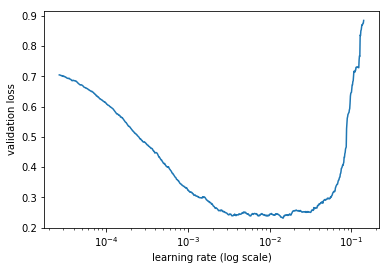

In [753]:
m.lr_find()
m.sched.plot(100)

In [754]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.255177   0.24276   
    1      0.207592   0.218491                                  
    2      0.184079   0.212893                                  


[array([0.21289])]

In [755]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.191512   0.207077  
    1      0.183388   0.208057                                  
    2      0.182913   0.204444                                  
    3      0.167426   0.200887                                  
    4      0.161784   0.19985                                   


[array([0.19985])]

In [756]:
m.fit(lr, 3, cycle_len=5, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.163667   0.194472  
    1      0.161693   0.193748                                  
    2      0.16126    0.1921                                    
    3      0.16037    0.193421                                  
    4      0.152603   0.19404                                   
    5      0.159625   0.190876                                  
    6      0.151736   0.197661                                  
    7      0.147254   0.190295                                  
    8      0.146903   0.187363                                  
    9      0.144905   0.192222                                  
    10     0.142675   0.192165                                  
    11     0.13419    0.189378                                  
    12     0.140847   0.189162                                  
    13     0.125223   0.189606                                  
    14     0.130871   0.18948                            

[array([0.18789])]

In [757]:
m.save(modelName)

In [758]:
m.load(modelName)

## Validation

In [759]:
def calculateAccuracy(df):
    successfulPredictions = df.loc[df.action == df.predicted]
    # total accuracy does not provide an accurate represantation
    # totalAccuracy = len(successfulPredictions)/len(df)
    totalBuyActions = df.loc[df.action == 1]
    totalSellActions = df.loc[df.action == 0]
    successfulBuyPredictions = successfulPredictions.loc[successfulPredictions.action == 1]
    successfulSellPredictions = successfulPredictions.loc[successfulPredictions.action == 0]
    buyAccuracy = len(successfulBuyPredictions)/len(totalBuyActions)
    sellAccuracy = len(successfulSellPredictions)/len(totalSellActions)
    result = {
        'F1Score': (buyAccuracy + sellAccuracy )/2,
        'buyAccuracy': buyAccuracy,
        'sellAccuracy': sellAccuracy,
        'totalBuyActions': len(totalBuyActions),
        'successfulBuyPredictions': len(successfulBuyPredictions)
    }
    return result
            
def calculateNetProfit(dataFrame, startAmount):
    df = dataFrame
    df['buyAmount'] = 0
    df['sellAmount'] = 0
    totalBuys = 0
    totalSells = 0
    for index, row in df.iterrows():
        if index == df.index[0]:
            df.loc[index,'buyAmount'] = startAmount
        elif row.predicted == 1 and df.loc[index -1,'buyAmount'] > 0:
            df.loc[index,'sellAmount'] = df.loc[index -1,'buyAmount']/row.Close
            totalBuys +=1
        elif row.predicted == 1 and df.loc[index -1,'buyAmount'] == 0:
            df.loc[index,'sellAmount'] = df.loc[index -1,'sellAmount']
        elif row.predicted == 0 and df.loc[index -1,'sellAmount'] > 0:
            df.loc[index,'buyAmount'] = df.loc[index -1,'sellAmount']*row.Close
            totalSells +=1
        elif row.predicted == 0 and df.loc[index -1,'sellAmount'] == 0:
            df.loc[index,'buyAmount'] = df.loc[index -1,'buyAmount']
            
    startClose = df.Close.iloc[0]
    endClose = df.Close.iloc[-1]
    endBuyAmount = df.buyAmount.iloc[-1]
    endSellAmount = df.sellAmount.iloc[-1]
    endAmount = endBuyAmount if (endBuyAmount > 0) else (endSellAmount * endClose)
    
    buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
    percentIncrease = ((endAmount - startAmount)/startAmount) * 100
    percentDifference = percentIncrease - buyAndHoldPercentIncrease
    
    result = {
        'startClose': startClose,
        'endClose': endClose,
        'startAmount': startAmount,
        'endAmount': endAmount,
        'buyAndHoldPercentIncrease':round(buyAndHoldPercentIncrease,3),
        'percentIncrease':round(percentIncrease,3),
        'percentDifference':round(percentDifference,3),
        'totalBuys':totalBuys,
        'totalSells':totalSells
    }
    return df,result


In [760]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [761]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0]))

In [762]:
y1.shape


(10000,)

In [763]:
val = train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({'Close':val.Close,'index':val.index, 'action':val.action, 'predicted':np.argmax(x,axis=1)})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2017-12-31 23:41:00,13989.799805,2017-12-31 23:41:00,0,0
2017-12-31 23:42:00,13959.870117,2017-12-31 23:42:00,0,0
2017-12-31 23:43:00,13930.000000,2017-12-31 23:43:00,1,1
2017-12-31 23:44:00,13890.950195,2017-12-31 23:44:00,1,1
2017-12-31 23:45:00,13929.959961,2017-12-31 23:45:00,1,1
2017-12-31 23:46:00,13889.009766,2017-12-31 23:46:00,1,1
2017-12-31 23:47:00,13941.610352,2017-12-31 23:47:00,0,0
2017-12-31 23:48:00,13942.349609,2017-12-31 23:48:00,0,0
2017-12-31 23:49:00,13927.339844,2017-12-31 23:49:00,1,1


Calculate the percent accuracy on the validation set

In [764]:
calculateAccuracy(valpred)

{'F1Score': 0.9100387956725768,
 'buyAccuracy': 0.9564538785703137,
 'sellAccuracy': 0.86362371277484,
 'totalBuyActions': 6407,
 'successfulBuyPredictions': 6128}

In [765]:
newdf,result = calculateNetProfit(valpred, 10000)
result

{'startClose': 13559.11,
 'endClose': 13694.09,
 'startAmount': 10000,
 'endAmount': 12881.003497522333,
 'buyAndHoldPercentIncrease': 0.995,
 'percentIncrease': 28.81,
 'percentDifference': 27.815,
 'totalBuys': 486,
 'totalSells': 485}

In [766]:
newdf.head(10)

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-12-25 02:41:00,13559.110352,2017-12-25 02:41:00,1,1,10000.0,0.000000
2017-12-25 02:42:00,13513.709961,2017-12-25 02:42:00,1,1,0.0,0.739989
2017-12-25 02:43:00,13501.219727,2017-12-25 02:43:00,1,1,0.0,0.739989
2017-12-25 02:44:00,13502.000000,2017-12-25 02:44:00,1,1,0.0,0.739989
2017-12-25 02:45:00,13500.000000,2017-12-25 02:45:00,1,1,0.0,0.739989
2017-12-25 02:46:00,13496.480469,2017-12-25 02:46:00,1,1,0.0,0.739989
2017-12-25 02:47:00,13430.000000,2017-12-25 02:47:00,1,1,0.0,0.739989
2017-12-25 02:48:00,13506.990234,2017-12-25 02:48:00,1,1,0.0,0.739989
2017-12-25 02:49:00,13551.030273,2017-12-25 02:49:00,1,1,0.0,0.739989


In [767]:
newdf.tail(10)

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-01 01:11:00,13614.030273,2018-01-01 01:11:00,1,1,0.0,0.940625
2018-01-01 01:12:00,13614.059570,2018-01-01 01:12:00,1,1,0.0,0.940625
2018-01-01 01:13:00,13600.000000,2018-01-01 01:13:00,1,1,0.0,0.940625
2018-01-01 01:14:00,13600.000000,2018-01-01 01:14:00,1,1,0.0,0.940625
2018-01-01 01:15:00,13599.000000,2018-01-01 01:15:00,1,1,0.0,0.940625
2018-01-01 01:16:00,13597.000000,2018-01-01 01:16:00,1,1,0.0,0.940625
2018-01-01 01:17:00,13644.959961,2018-01-01 01:17:00,1,1,0.0,0.940625
2018-01-01 01:18:00,13618.469727,2018-01-01 01:18:00,1,1,0.0,0.940625
2018-01-01 01:19:00,13647.469727,2018-01-01 01:19:00,1,1,0.0,0.940625


## Test

In [768]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [769]:
testPred = pd.DataFrame({'Timestamp':test.index, 'Close':test.Close, 'action':test.action, 'predicted':np.argmax(m.predict(True), axis =1)})[['Close','Timestamp', 'action', 'predicted']]
testPred.head(10)

,Close,Timestamp,action,predicted
Timestamp,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,0,1
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,0,1
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,0,1
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1


Calculate the percent accuracy on the test set

In [770]:
calculateAccuracy(testPred)

{'F1Score': 0.882506941868612,
 'buyAccuracy': 0.9449183976261127,
 'sellAccuracy': 0.8200954861111112,
 'totalBuyActions': 5392,
 'successfulBuyPredictions': 5095}

In [771]:
newdf,result = calculateNetProfit(testPred, 10000)
result

{'startClose': 13694.11,
 'endClose': 16166.78,
 'startAmount': 10000,
 'endAmount': 17594.46303466075,
 'buyAndHoldPercentIncrease': 18.056,
 'percentIncrease': 75.945,
 'percentDifference': 57.888,
 'totalBuys': 577,
 'totalSells': 576}

In [772]:
newdf.head(10)

,Close,Timestamp,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,0,1,10000.0,0.000000
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,0,1,0.0,0.729753
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,0,1,0.0,0.729753
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1,0.0,0.729753
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1,0.0,0.729753
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1,0.0,0.729753
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1,0.0,0.729753
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1,0.0,0.729753
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1,0.0,0.729753


In [773]:
newdf.tail(10)

,Close,Timestamp,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-07 23:51:00,16180.490234,2018-01-07 23:51:00,1,1,0.0,1.08831
2018-01-07 23:52:00,16178.660156,2018-01-07 23:52:00,1,1,0.0,1.08831
2018-01-07 23:53:00,16155.009766,2018-01-07 23:53:00,1,1,0.0,1.08831
2018-01-07 23:54:00,16167.889648,2018-01-07 23:54:00,1,1,0.0,1.08831
2018-01-07 23:55:00,16165.009766,2018-01-07 23:55:00,1,1,0.0,1.08831
2018-01-07 23:56:00,16154.599609,2018-01-07 23:56:00,1,1,0.0,1.08831
2018-01-07 23:57:00,16176.429688,2018-01-07 23:57:00,1,1,0.0,1.08831
2018-01-07 23:58:00,16114.299805,2018-01-07 23:58:00,1,1,0.0,1.08831
2018-01-07 23:59:00,16124.019531,2018-01-07 23:59:00,1,1,0.0,1.08831


In [774]:
# csv_fn=f'{PATH}/tmp/sub4.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

## Random Forest

In [775]:
from sklearn.ensemble import RandomForestRegressor

In [776]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [777]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [778]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

Accuracy on the validation set using a Random Forest Regressor

In [779]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

(0.9659524433958344, 0.7322206620543836, 0.8415632377997826, 0.92)

In [780]:
preds_test = m.predict(df_test.values)

In [781]:
sub = pd.DataFrame({'Timestamp':test.index, 'action':PredtoClass(preds_test)})[['Timestamp', 'action']]
sub.head(10)

,Timestamp,action
0,2018-01-01 01:21:00,0
1,2018-01-01 01:22:00,0
2,2018-01-01 01:23:00,0
3,2018-01-01 01:24:00,1
4,2018-01-01 01:25:00,1
5,2018-01-01 01:26:00,1
6,2018-01-01 01:27:00,1
7,2018-01-01 01:28:00,1
8,2018-01-01 01:29:00,1
9,2018-01-01 01:30:00,1


In [782]:
# csv_fn=f'{PATH}/tmp/RFsub5.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)